# Evaluating the model

The final stage, evaluating the model. We have a test set composed by $200$ classes, each class with $50$ images. We consider two metrics rank-1 and rank-5. Rank-1 is the accuracy. Beyond these metrics, we also consider the error rate, calculated as $ER = 1 - rank1$. This metrics measures how our model generalizes the main characteristics of the dataset.

## Importing libraries

In [1]:
from config import tiny_imagenet_config as config
from compvis.preprocessing import ImageToArrayPreprocessor
from compvis.preprocessing import SimplePreprocessor
from compvis.preprocessing import MeanPreprocessor
from compvis.utils.ranked import rank5_accuracy
from compvis.io import HDF5DatasetGenerator
from tensorflow.keras.models import load_model
import json
import numpy as np
import matplotlib.pyplot as plt

## Visualizing the training results

At the end of the training, we have a json file with all history of the training. We consider this file to plot the results of accuracy and loss function, for the training and validation set.

In [2]:
results = json.loads(open(config.JSON_PATH).read()) # reading the json file

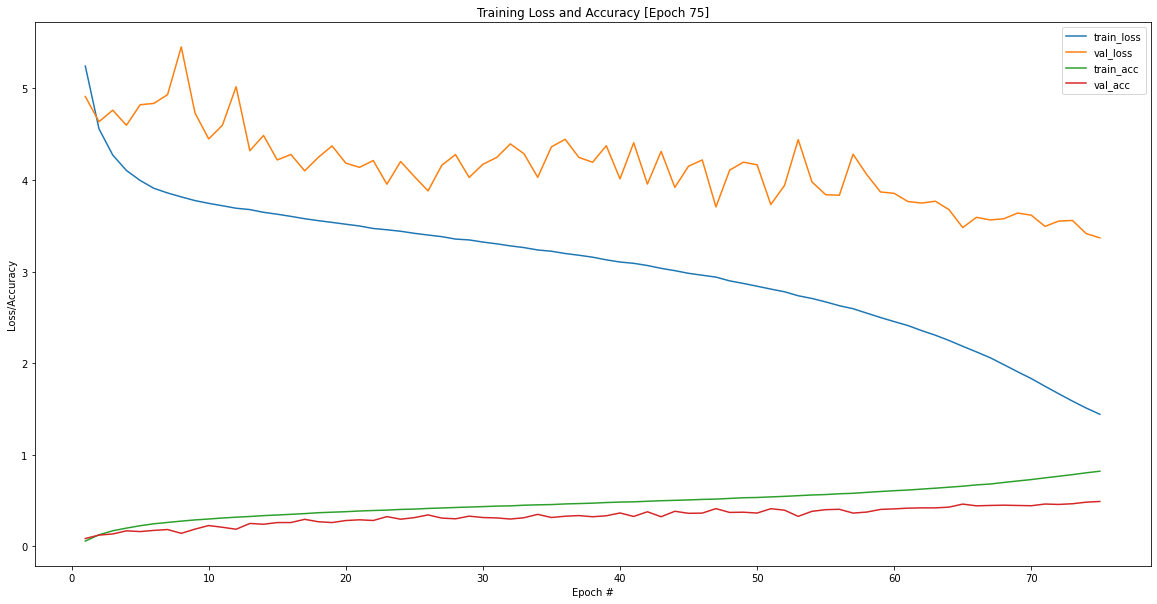

In [3]:
N = np.arange(1, len(results["loss"])+1) # range of epochs
plt.figure(figsize=(20,10))
plt.plot(N, results["loss"], label="train_loss")
plt.plot(N, results["val_loss"], label="val_loss")
plt.plot(N, results["accuracy"], label="train_acc")
plt.plot(N, results["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy [Epoch {}]".format(len(results["loss"])))
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

As we can see, the model does not have a great accuracy on the validation set. For the test set the value is around $0.8215$ and $0.4913$ for the validation set. We can also remark an interesting thing, the loss functions, there's a gap between the curves for the training and validation set, but the behavior is similar, both curves are decreasing at the end of the training, maybe there's no over-fit.

## Loading and preprocessing the test set

**RGB mean file**

In [4]:
# load the RGB means for the training set
means = json.loads(open(config.DATASET_MEAN).read())

**Data preprocessors**

In [5]:
sp = SimplePreprocessor(64, 64)
mp = MeanPreprocessor(means["R"], means["G"], means["B"])
iap = ImageToArrayPreprocessor()

**Generating the test set**

In [6]:
testGen = HDF5DatasetGenerator(config.TEST_HDF5, 64,
                               preprocessors=[sp, mp, iap], 
                               classes=config.NUM_CLASSES)

## Loading the model

In [7]:
model = load_model(config.MODEL_PATH)

**Predicting on the test set**

In [8]:
predictions = model.predict(testGen.generator(), 
                            steps=testGen.numImages // 64,
                            max_queue_size=64 * 2)

## Scores

The rank1 is calculated as the accuracy, with the prediction is true, it increases the accuracy value. The rank5 is a bit different, in this case, we consider the top five predictions, if the class is on the top five, the value increases.

In [9]:
# compute the rank-1 and rank-5 accuracies
(rank1, rank5) = rank5_accuracy(predictions, testGen.db["labels"])

In [10]:
print("[INFO] rank-1: {:.2f}%".format(rank1 * 100))
print("[INFO] rank-5: {:.2f}%".format(rank5 * 100))
print("[INFO] error rate: {:.4f}".format(1-rank1))

[INFO] rank-1: 48.74%
[INFO] rank-5: 72.99%
[INFO] error rate: 0.5126


## Conclusions

We've trained the ResNet model from scratch on the Tiny ImageNet dataset. The error rate was $0.51$, we had a gain in comparison with the GoogLeNet. The result did not reach the rank of top results, we can try others parameter or regularization, as well get more data to improve the results. The problem to perform all of these possible solutions is the running time, I can't do it due a machine limitation. The results are good, but the model is not efficient to real word tasks. If I need an accurate model, I'll looking for a pre-trained model to apply transfer learning.